In [1]:
%gui qt

In [1]:
import napari
import sys
Linux = True
if Linux:
    sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
else:
    sys.path.insert(0,'C:\\Users\\gh464\\Documents\\GitHub\\SYMPTOMM2\\')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import gc
from SYMPTOMM.PSF import get_phase_contrast_kernel, get_condensers
import warnings
from scipy.ndimage import gaussian_filter
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(20,24)).zfill(3)))[26:-1,:]

if real_image.shape[0]%2 == 1:
    warnings.warn("Synthetic image has odd Y-axis dimension, Fourier matching will produce bad results")
    
#viewer = napari.view_image(real_image)


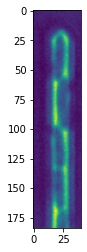

In [2]:
plt.imshow(real_image)

In [3]:
16*12

192

In [4]:
real_image.shape

(184, 40)

### Scope props

In [5]:
condensers = get_condensers()

W, R, diameter = condensers["Ph2"]
radius=50
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.10837 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=4
NA=0.97
n = 1
kernel_params = (R,W,radius,scale,NA,n,sigma,λ)

#kernel_params = (R,W,radius,scale,F,sigma,λ)


### Do large cells

In [6]:
sim_length = 1000
cell_timeseries, space = run_simulation(
    trench_length=17.5, 
    trench_width=1.5, 
    cell_max_length=5.7, 
    cell_width=1., 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=0,
    phys_iters=15,
    max_length_var = 3,
    width_var = 0.03,
    save_dir="/home/georgeos/"
) # growth phase


main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = True
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Timeseries Properties:   0%|          | 0/1000 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 2
x_border_expansion_coefficient = 3




temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient,
    fluorescence = False,
    defocus = 0
)
### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)



/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:105: RuntimeWarning: invalid value encountered in true_divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:108: RuntimeWarning: invalid value encountered in true_divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr


In [8]:
viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [10]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

In [15]:
def generate_test_comparison(media_multiplier, cell_multiplier, device_multiplier, sigma, scene_no, scale, match_fourier, match_histogram, match_noise, offset, debug_plot, noise_var, main_segments, scenes, kernel_params, resize_amount, real_image, image_params, error_params, x_border_expansion_coefficient,y_border_expansion_coefficient,fluorescence,blur_sigma):
    
    
    expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
        main_segments=main_segments,
        offset=offset,
        scene = scenes[scene_no][0],
        mask = scenes[scene_no][1],
        media_multiplier=media_multiplier,
        cell_multiplier=cell_multiplier,
        device_multiplier=device_multiplier,
        x_border_expansion_coefficient = x_border_expansion_coefficient,
        y_border_expansion_coefficient = y_border_expansion_coefficient,
        fluorescence = fluorescence
    )



    R,W,radius,scale,NA,n,_,λ = kernel_params
    
    
    real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars = image_params
    mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error = error_params
    
    if fluorescence:
        kernel = get_fluorescence_kernel(radius=radius, scale=scale, NA=NA,n=n, Lambda=λ)[0]
    else:
        kernel = get_phase_contrast_kernel(R=R, W=W, radius=radius, scale=scale, NA=NA,n=n, sigma=sigma, λ=λ)
        kernel = gaussian_filter(kernel,sigma=blur_sigma,mode="reflect")



    convolved = convolve_rescale(expanded_scene, kernel, 1/resize_amount, rescale_int = True)
    real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)
    
    if match_fourier:
        fftim1 = fft.fftshift(fft.fft2(real_resize))
        angs, mags = cart2pol(np.real(fftim1),np.imag(fftim1))
        matched = sfMatch([real_resize, expanded_resized],tarmag = mags)[1]
        matched = lumMatch([real_resize,matched],None,[np.mean(real_resize),np.std(real_resize)])[1]
    else:
        matched = expanded_resized
    
    if match_histogram and match_fourier:
        matched = match_histograms(matched, real_resize, multichannel=False)

        fftim1 = fft.fftshift(fft.fft2(real_resize))
        angs, mags = cart2pol(np.real(fftim1),np.imag(fftim1))
        matched = sfMatch([real_resize, matched],tarmag = mags)[1]
        matched = lumMatch([real_resize,matched],None,[np.mean(real_resize),np.std(real_resize)])[1]
    else:
        pass
    if match_histogram:
        matched = match_histograms(matched, real_resize, multichannel=False)
    else:
        pass
    
    noisy_img = random_noise(rescale_intensity(matched), mode="poisson")
    noisy_img = random_noise(rescale_intensity(noisy_img), mode="gaussian", mean=0,var=noise_var,clip=False)
    
    if match_noise:
        noisy_img = match_histograms(noisy_img, real_resize, multichannel=False)
    else:
        pass
    noisy_img = rescale_intensity(noisy_img.astype(np.float32), out_range=(0,1))
    
    ## getting the cell mask to the right shape
    expanded_mask_resized = rescale(expanded_mask, 1/resize_amount, anti_aliasing=False, preserve_range=True,order=0)
    if len(np.unique(expanded_mask_resized)) > 2:
        _, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=False)
    else:
        _, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=True)


    

    
    expanded_media_mask = rescale((expanded_scene_no_cells == device_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool) , 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_media_mask = make_images_same_shape(real_image,expanded_media_mask, rescale_int=True)
    just_media = expanded_media_mask * noisy_img
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale_int=True)
    just_cells = expanded_cell_pseudo_mask * noisy_img
    if True:
        expanded_device_mask = expanded_scene_no_cells
    else:
        expanded_device_mask = expanded_scene_no_cells == media_multiplier
    expanded_device_mask = rescale(expanded_device_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_device_mask = make_images_same_shape(real_image,expanded_device_mask, rescale_int=True)
    just_device = expanded_device_mask * noisy_img
    
    
    
    
    simulated_means = np.array([just_media[np.where(just_media)].mean(), just_cells[np.where(just_cells)].mean(), just_device[np.where(just_device)].mean()])
    simulated_vars = np.array([just_media[np.where(just_media)].var(), just_cells[np.where(just_cells)].var(), just_device[np.where(just_device)].var()])

    
    
    
    if fluorescence:
        mean_error.append(perc_diff(np.mean(noisy_img),np.mean(real_resize)))
        mean_var_error.append(perc_diff(np.var(noisy_img),np.var(real_resize)))
    else:
        mean_error.append(np.mean(perc_diff(real_means, simulated_means)))
        media_error.append(perc_diff(simulated_means[0], real_media_mean))
        cell_error.append(perc_diff(simulated_means[1], real_cell_mean))
        device_error.append(perc_diff(simulated_means[2], real_device_mean))


        mean_var_error.append(np.mean(perc_diff(real_vars, simulated_vars)))
        media_var_error.append(perc_diff(simulated_vars[0], real_media_var))
        cell_var_error.append(perc_diff(simulated_vars[1], real_cell_var))
        device_var_error.append(perc_diff(simulated_vars[2], real_device_var))
    if debug_plot == True:
        fig = plt.figure(figsize=(15,5))
        ax1 = plt.subplot2grid((1,8),(0,0),colspan=1,rowspan=1)
        ax2 = plt.subplot2grid((1,8),(0,1),colspan=1,rowspan=1)
        ax3 = plt.subplot2grid((1,8),(0,2),colspan=3,rowspan=1)
        ax4 = plt.subplot2grid((1,8),(0,5),colspan=3,rowspan=1)
        ax1.imshow(noisy_img,cmap="Greys_r")
        ax1.set_title("Synthetic")
        ax1.axis("off")
        ax2.imshow(real_resize,cmap="Greys_r")
        ax2.set_title("Real")
        ax2.axis("off")
        ax3.plot(mean_error)
        ax3.plot(media_error)
        ax3.plot(cell_error)
        ax3.plot(device_error)
        ax3.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax3.set_title("Intensity Error")

        ax4.plot(mean_var_error)
        ax4.plot(media_var_error)
        ax4.plot(cell_var_error)
        ax4.plot(device_var_error)
        ax4.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax4.set_title("Variance Error")

        fig.tight_layout()
        plt.show()
        plt.close()
    else:
        return noisy_img, expanded_mask_resized_reshaped.astype(int)

In [12]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,len(scenes)-1,1),
    noise_var=(0,0.01, 0.0001),
    scale=fixed(scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient),
    fluorescence=[False,True],
    defocus=(0,20,0.005)
);

In [ ]:
9

In [13]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [19]:
generate_training_data(interactive_output = params, sample_amount = 0.06, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  1000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data_DELTA_fourier/")


Sample generation:  52%|█████▏    | 518/1000 [00:45<00:41, 11.70it/s]

KeyboardInterrupt: 